In [1]:
# colab setup
import os
import subprocess as sp
import sys
from pathlib import Path

from rich.console import Console

console = Console()

# --- Colab detection ---
try:
    import google.colab  # noqa

    IS_COLAB = True
except ImportError:
    IS_COLAB = False

REPO = "https://github.com/haeussma/chromhandler-example.git"
BRANCH = "main"

# --- Colab-only repo setup ---
if IS_COLAB:
    base = Path("/content")
    name = Path(REPO).name.removesuffix(".git")
    dest = base / name
    if dest.exists():
        sp.run(["git", "-C", str(dest), "fetch", "origin", BRANCH], check=True)
        sp.run(["git", "-C", str(dest), "checkout", BRANCH], check=True)
        sp.run(
            ["git", "-C", str(dest), "reset", "--hard", f"origin/{BRANCH}"], check=True
        )
    else:
        sp.run(
            ["git", "clone", "--depth", "1", "--branch", BRANCH, REPO, str(dest)],
            check=True,
        )
    if Path.cwd().resolve() != dest.resolve():
        os.chdir(dest)
    console.log(f"Current directory: [bold]{Path.cwd()}[/]")
else:
    pass

# --- Colab-only install ---
if IS_COLAB:
    cmd = [
        sys.executable,
        "-m",
        "pip",
        "install",
        "chromhandler>=0.10.2",
        "ipywidgets>=8.1.7",
        "ipykernel>=6.30.1",
        "git+https://github.com/JR-1991/Catalax@master",
    ]
    with console.status("[bold green]Installing packages…[/]", spinner="dots"):
        sp.run(
            [
                sys.executable,
                "-m",
                "pip",
                "install",
                "-U",
                "pip",
                "setuptools",
                "wheel",
            ],
            check=True,
        )
        sp.run(cmd, check=True)
else:
    pass

# --- Import with friendly error ---
try:
    import chromhandler as ch  # noqa: F401
except ImportError as e:
    console.print(f"[bold red]ImportError:[/] {e}")
    console.print(
        "[red]If this was a fresh install in Colab/Jupyter, restart the kernel and run the cell again.[/]"
    )
    raise


In [2]:
import catalax as ctx

ctx.set_host_count(4)
import catalax.mcmc as cmc
import pyenzyme as pe

/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1030: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1038: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


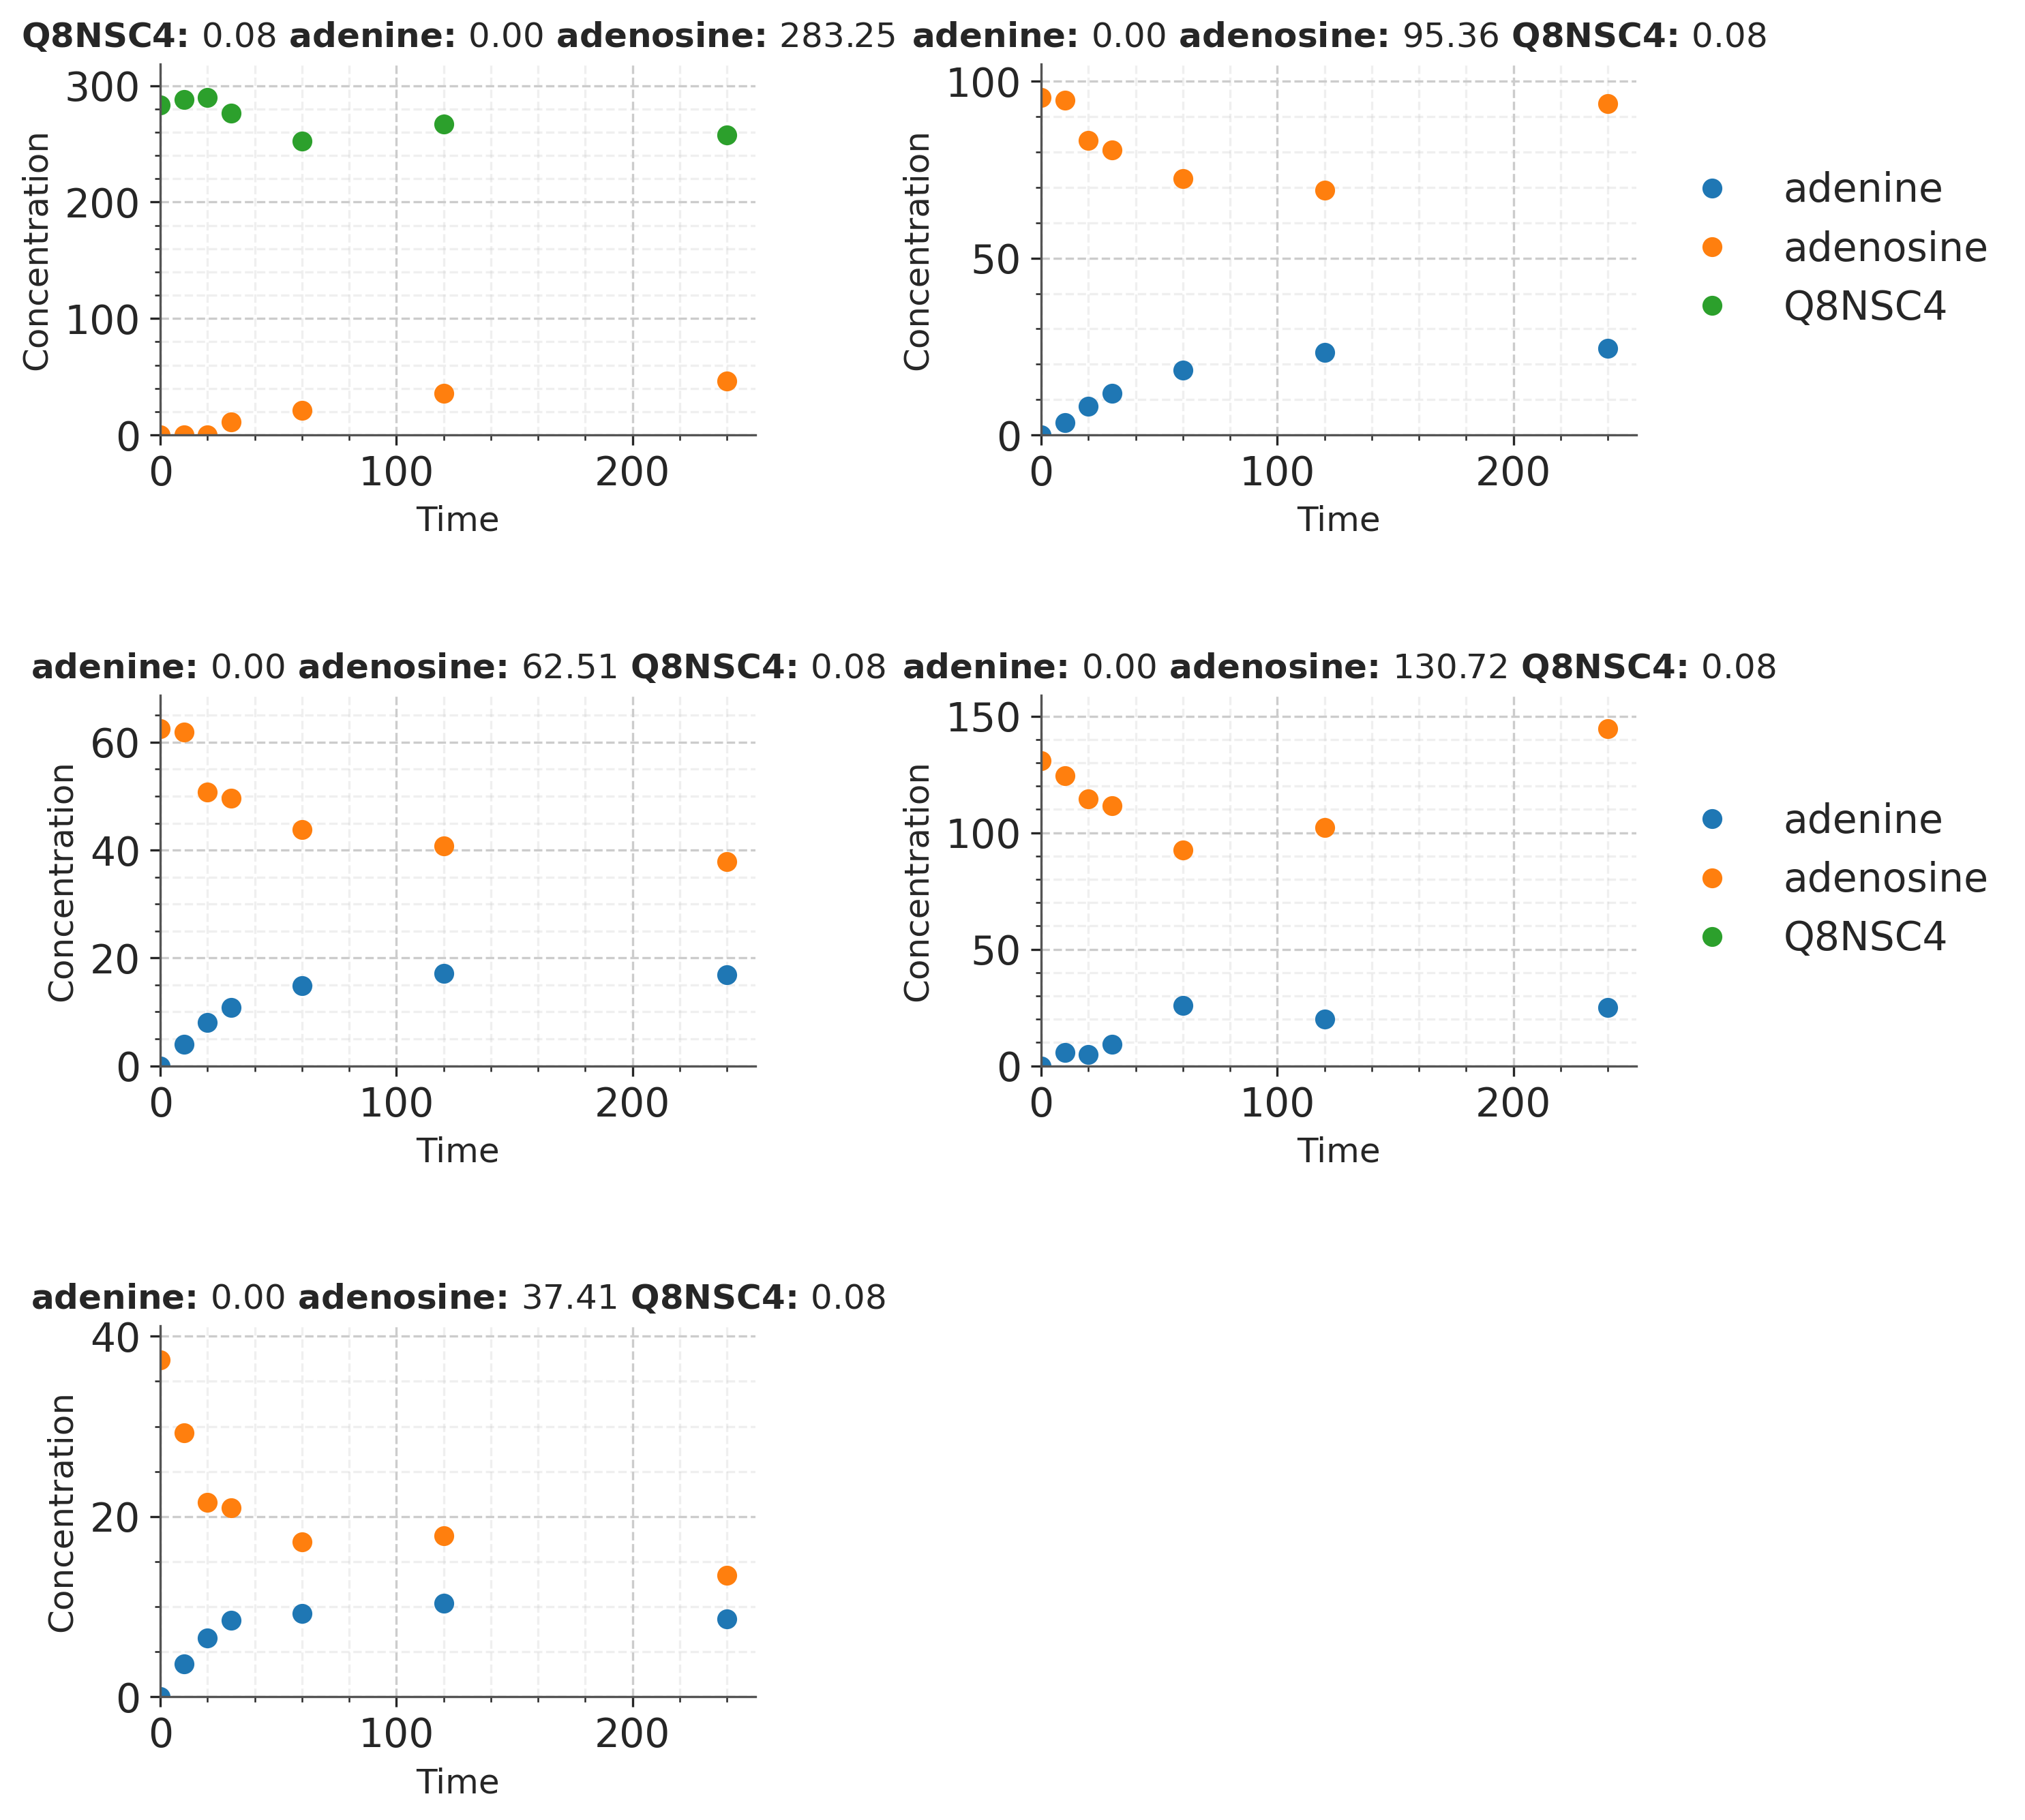

In [3]:
# read in enzymeml
doc = pe.read_enzymeml("data/enzymeml.json")
dataset = ctx.Dataset.from_enzymeml(doc)
dataset = dataset.pad()

dataset.plot(show=True)

In [4]:
ds, model = ctx.from_enzymeml(doc)

## Define model

In [5]:
model = ctx.Model(name="reversible MM")
model.add_species("Q8NSC4, adenine, adenosine")
model

KEQ = 1.3

model.add_ode(
    "adenine",
    "(( (vf/km_adenosine) * (adenosine - adenine/KEQ) ) / "
    "(1 + adenosine/km_adenosine + adenine/km_adenine))".replace("KEQ", str(KEQ)),
)
model.add_ode(
    "adenosine",
    "-(( (vf/km_adenosine) * (adenosine - adenine/KEQ) ) / "
    "(1 + adenosine/km_adenosine + adenine/km_adenine))".replace("KEQ", str(KEQ)),
)

model.add_ode(
    "Q8NSC4",
    "0",
)

model.parameters["vf"].prior = cmc.priors.LogUniform(low=0.01, high=1000)
model.parameters["km_adenosine"].prior = cmc.priors.LogUniform(low=0.01, high=1000)
model.parameters["km_adenine"].prior = cmc.priors.LogUniform(low=0.01, high=1000)

In [6]:
hmc = cmc.HMC(
    num_warmup=2000,
    num_samples=2000,
    dt0=0.1,
    max_steps=64**4,
    verbose=1,
    num_chains=4,
    chain_method="parallel",
)

results = hmc.run(model=model, dataset=dataset, yerrs=2.0)

# Apply the median posterior to the model
fitted_model = results.get_fitted_model()

# Print the summary
results.summary()



🚀 Running MCMC



  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
km_adenine,0.191,0.355,0.010,0.762,0.007,0.020,844.0,565.0,1.0
km_adenosine,13.672,53.287,0.052,50.897,1.716,7.252,1116.0,1217.0,1.0
sigma,4.921,0.503,3.916,5.901,0.009,0.008,3198.0,2883.0,1.0
vf,4.550,28.444,0.257,6.015,0.853,4.242,1657.0,685.0,1.0


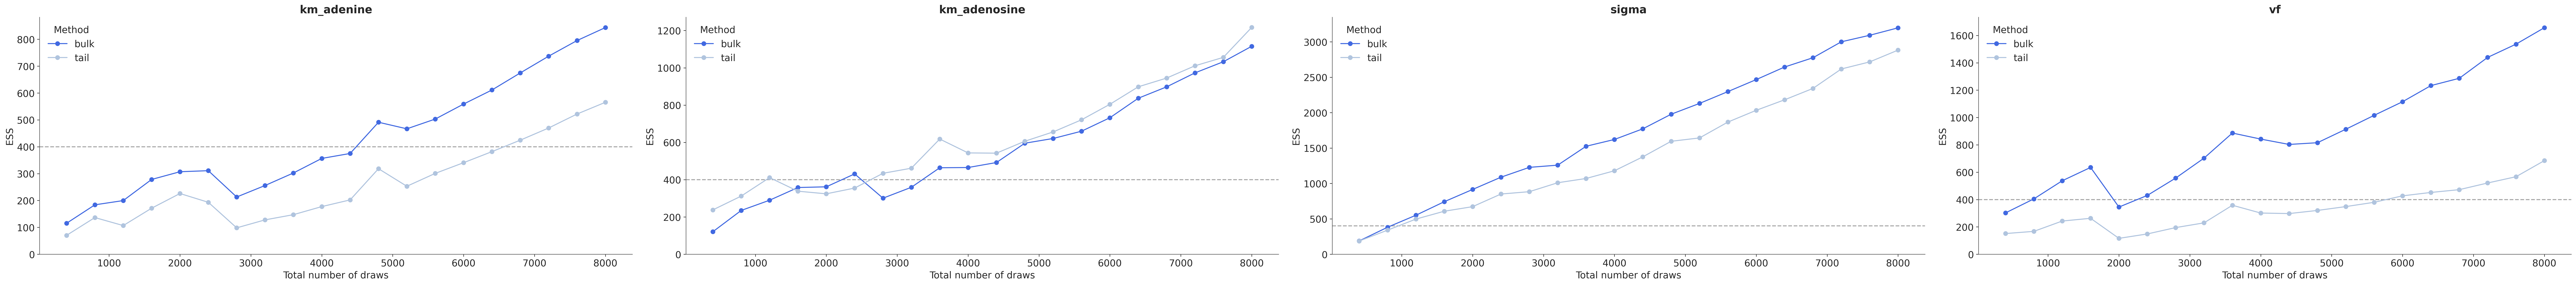

/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/mcmc/plotting.py:56: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


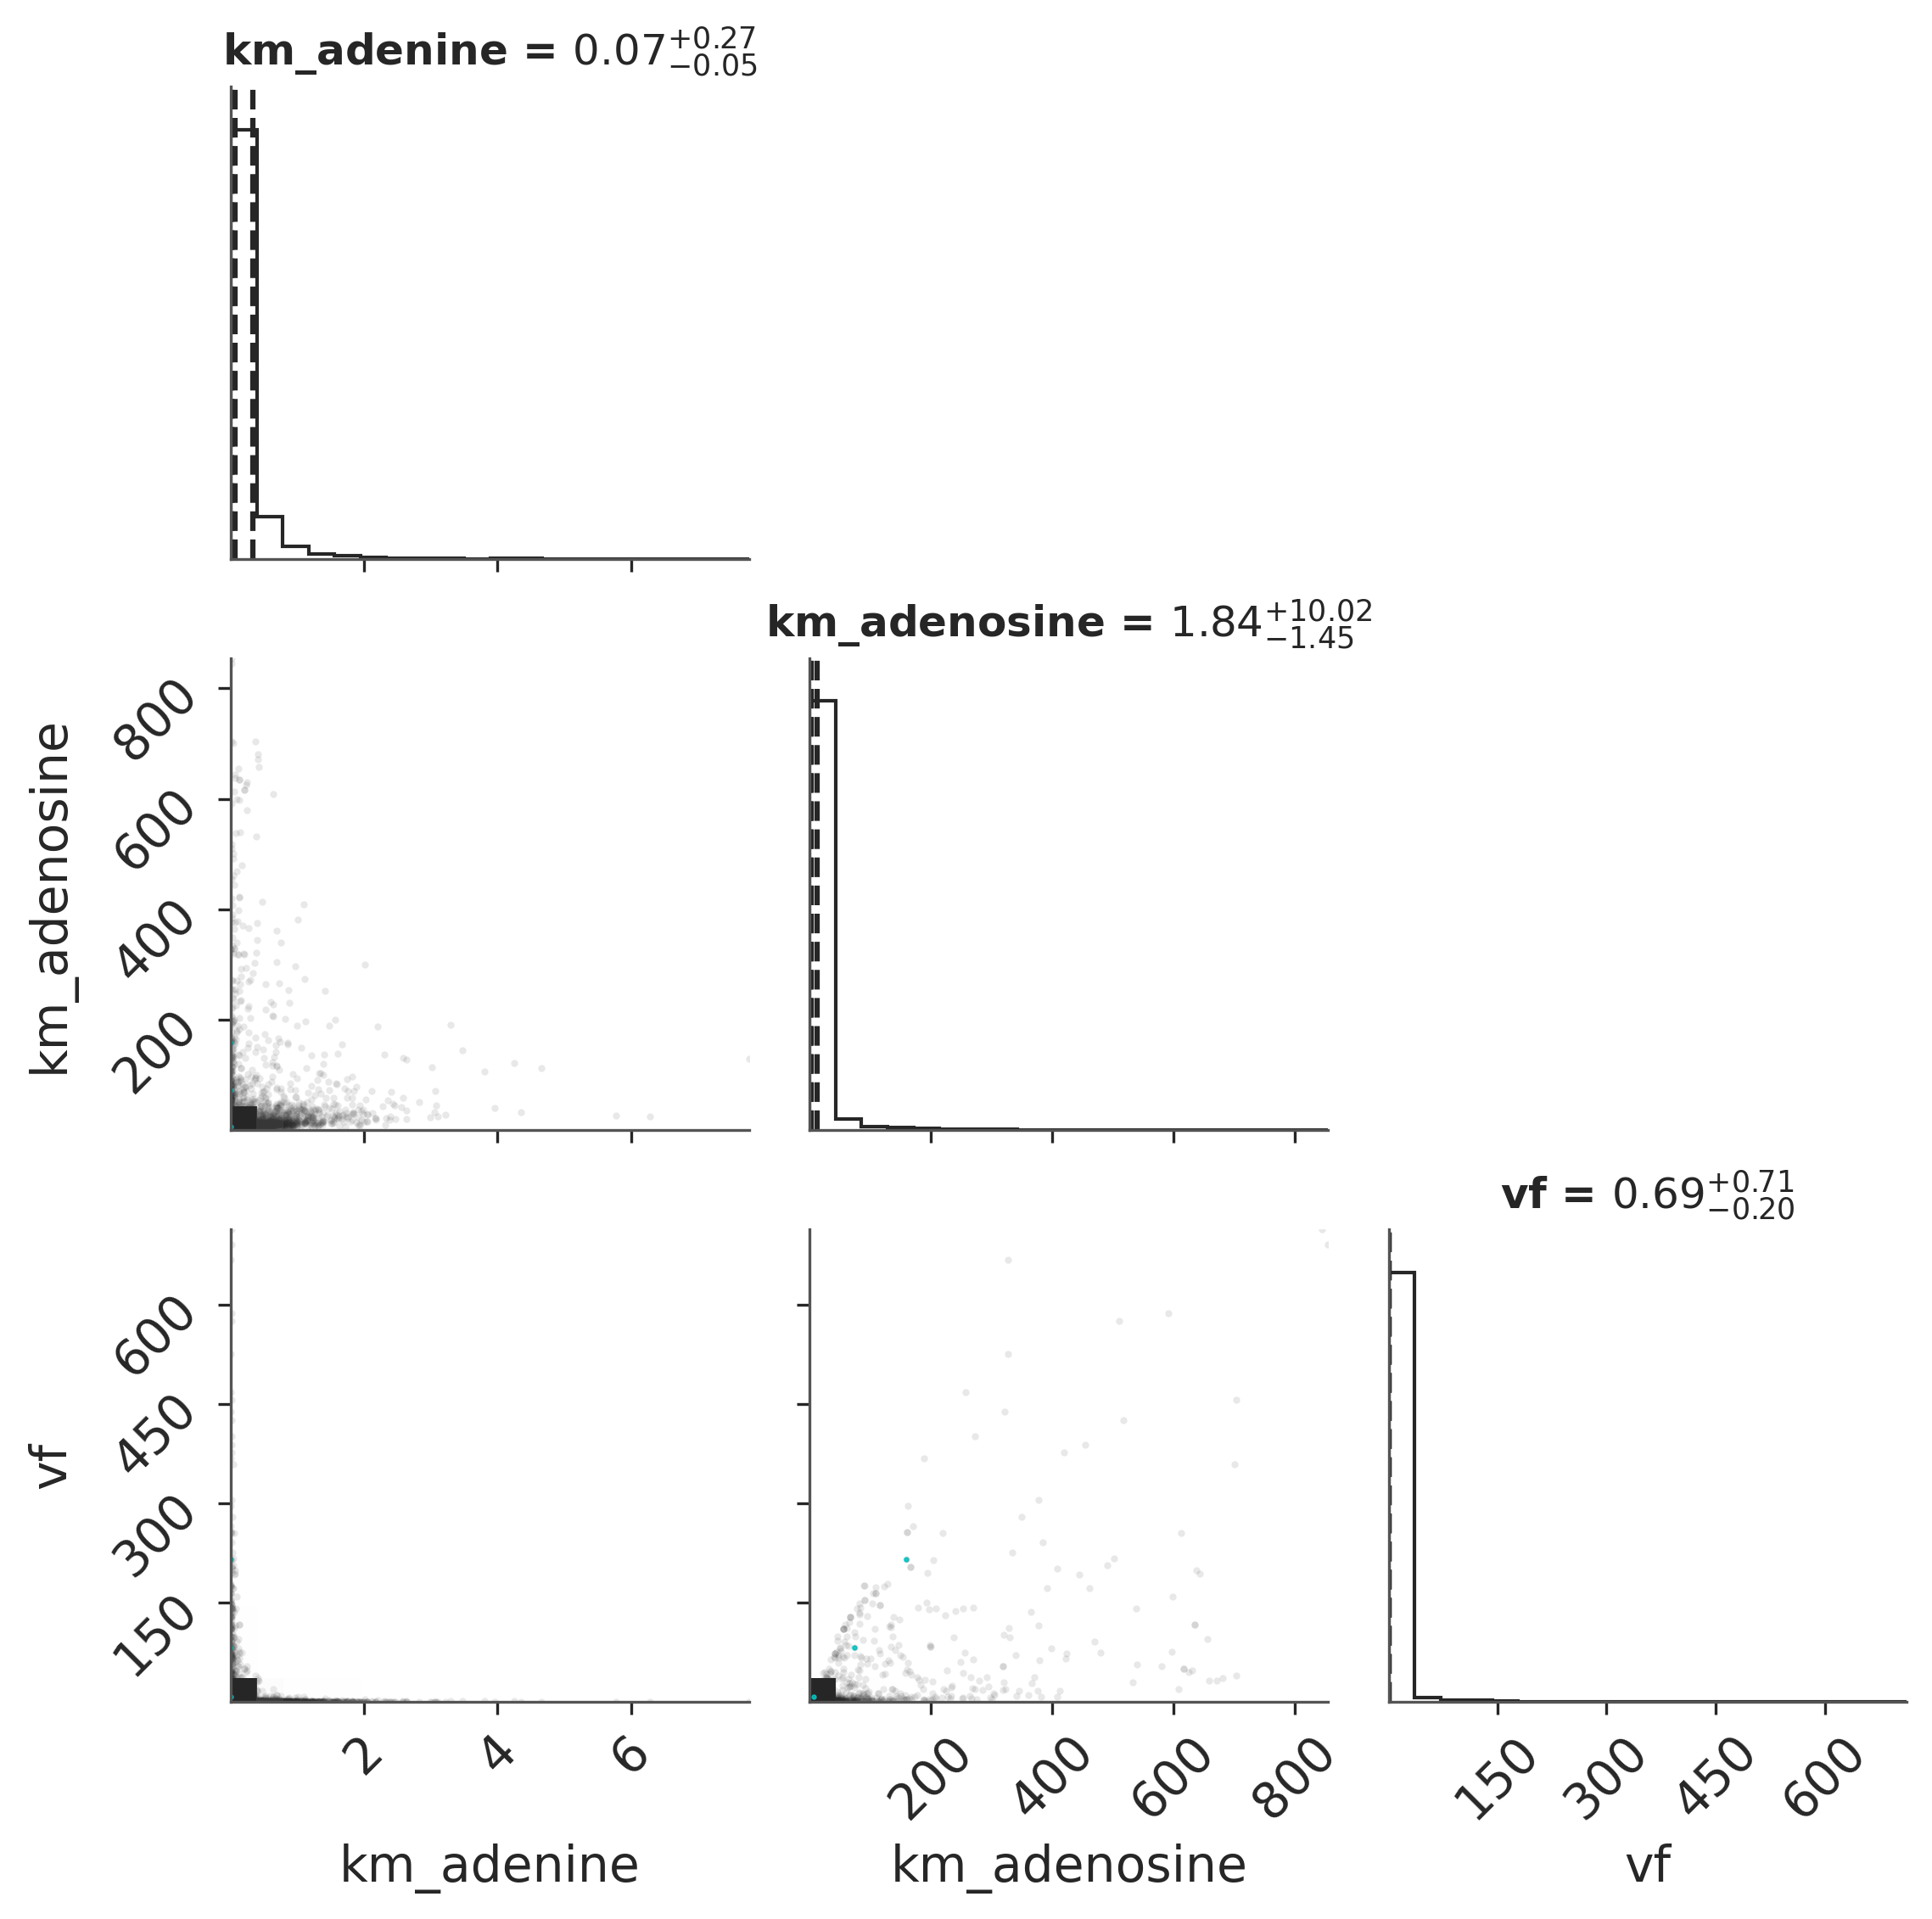

In [7]:
# Plot the trace
results.plot_ess(show=True)

# Plot the corner
results.plot_corner(show=True)


/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1038: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


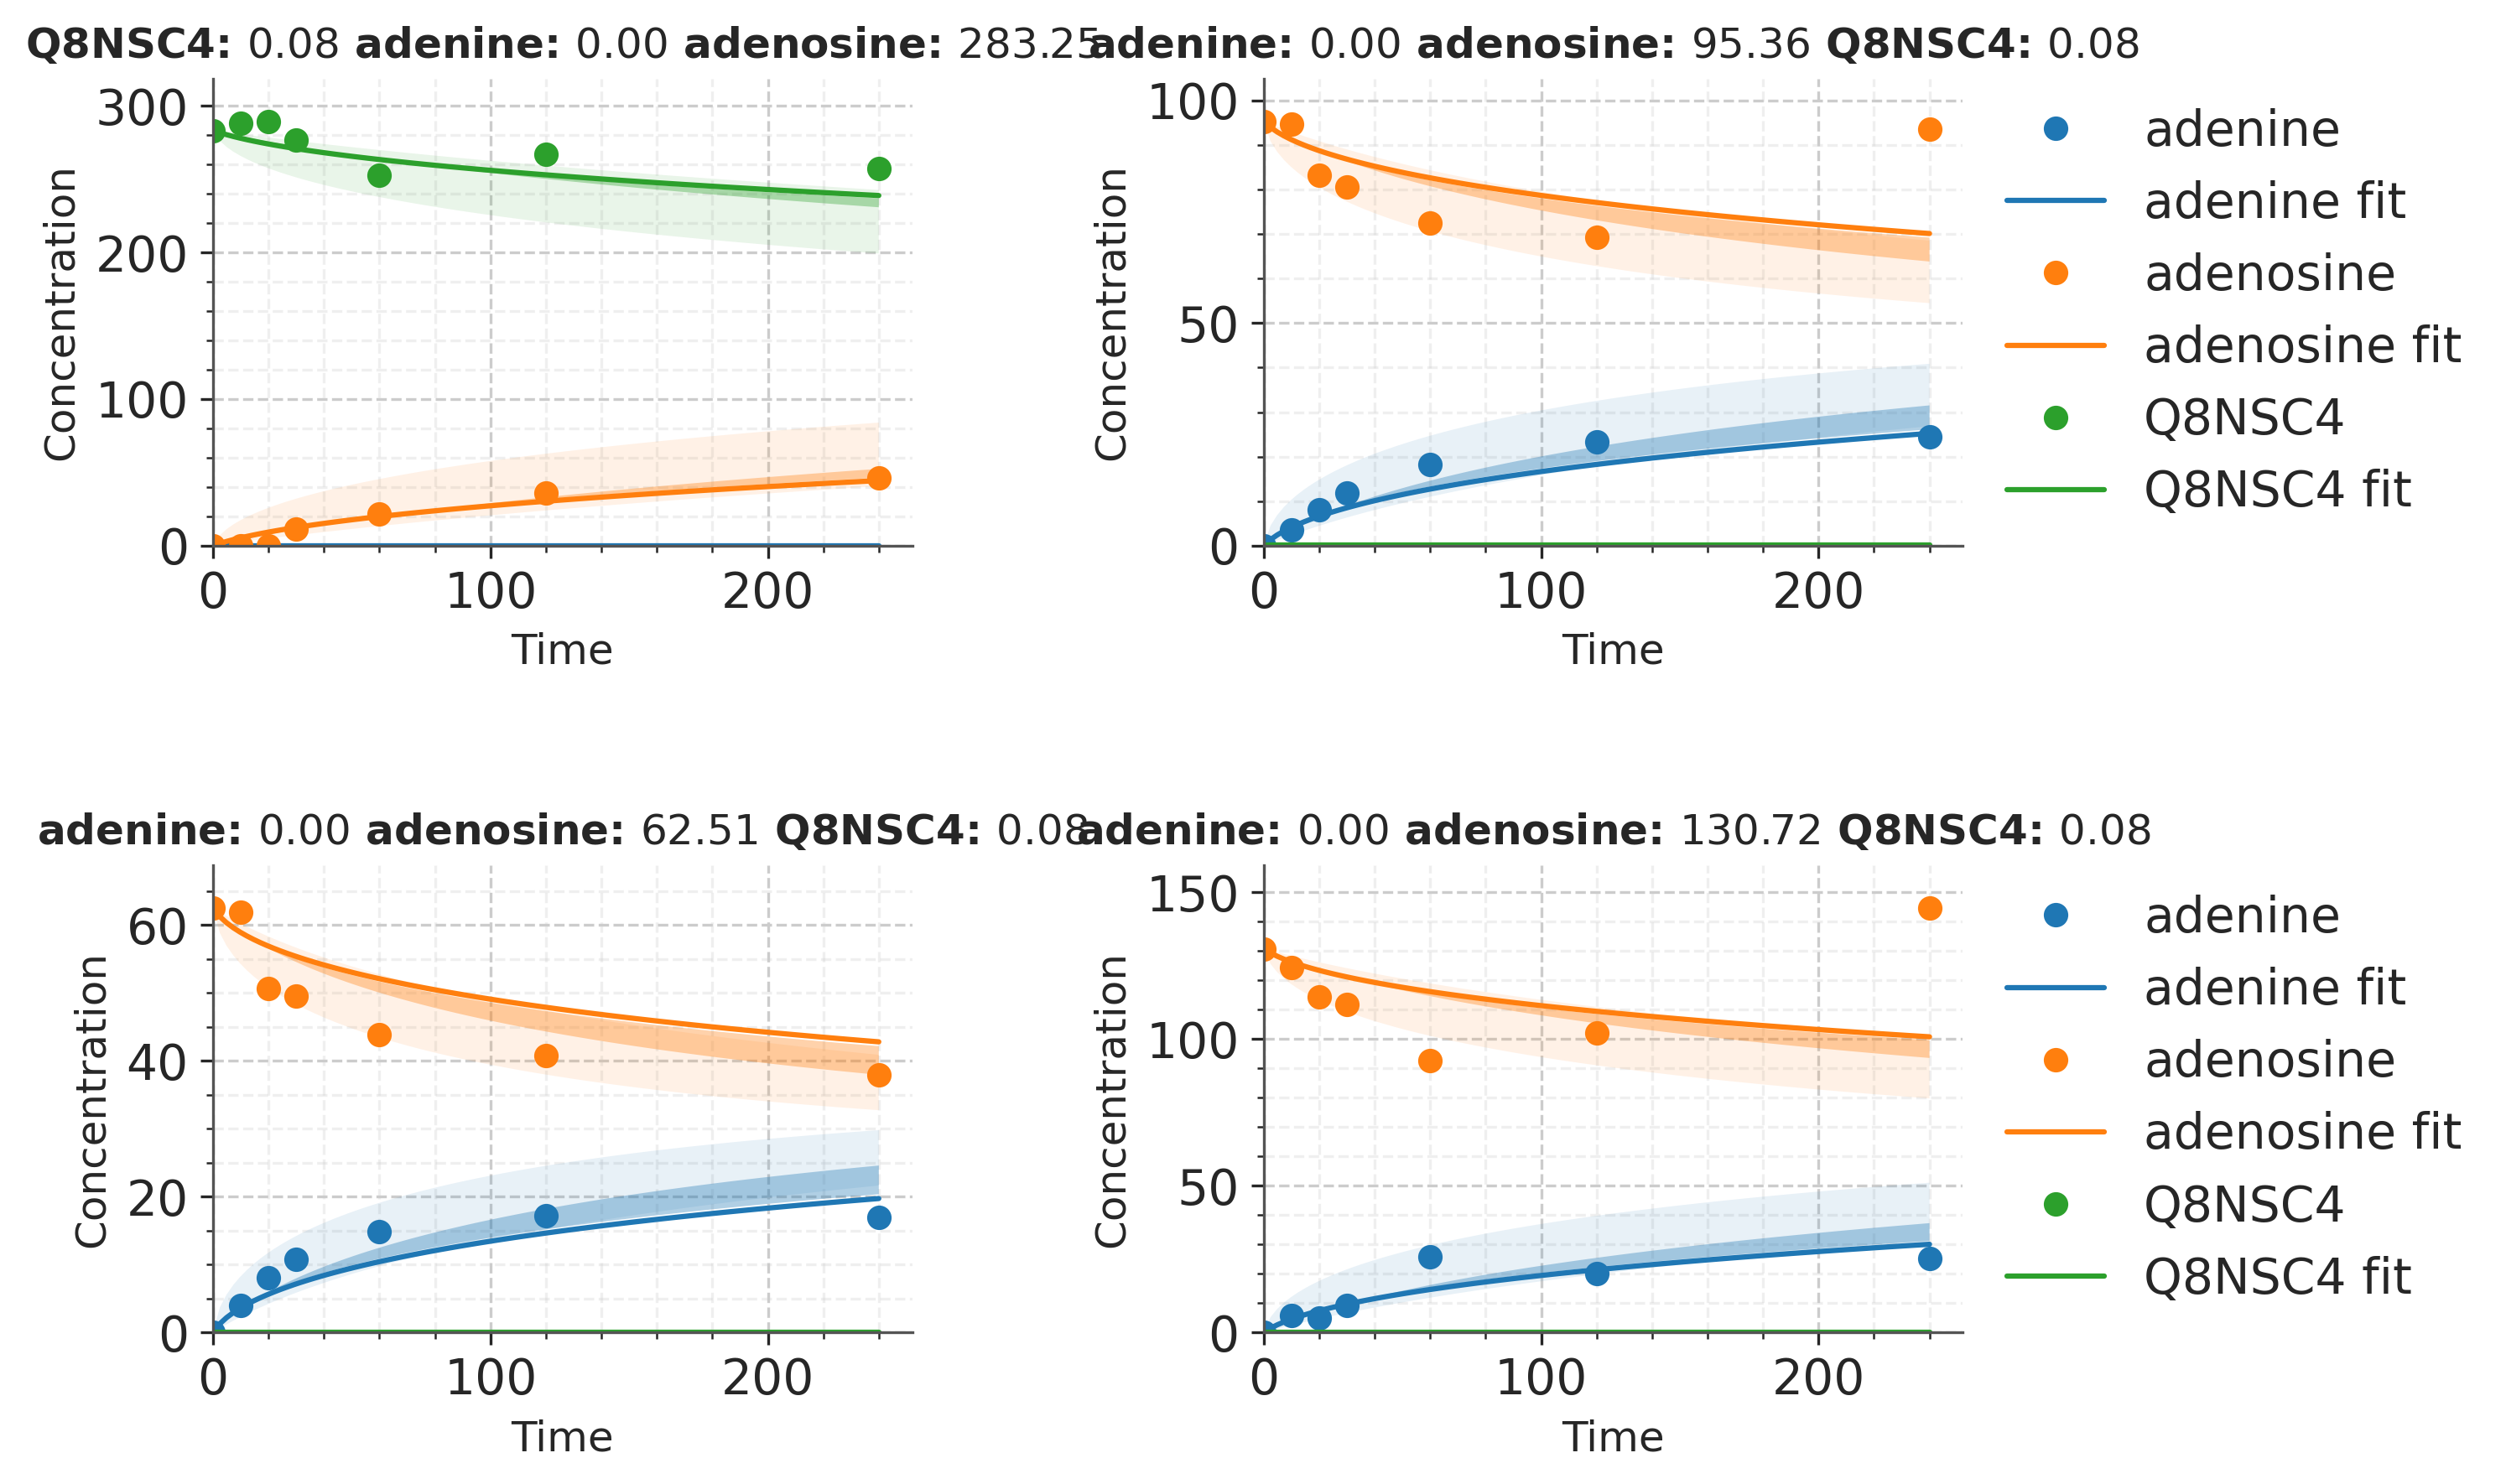

In [8]:
dataset.plot(
    predictor=fitted_model,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=True,
)
